# Validation of the binary ML classificator to accelerate monte carlo methods.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import otaf

# AI stuff
from efficient_kan import KAN, KANLinear
from lion_pytorch import Lion

# AI stuff
from efficient_kan import KAN, KANLinear
from lion_pytorch import Lion

In [2]:
# Function to create samples
def create_samples(n_samples, n_dimensions, distribution_type='normal', **kwargs):
    """
    Generates samples from a specified distribution.
    
    Args:
        n_samples (int): Number of samples to generate.
        n_dimensions (int): Number of dimensions for each sample.
        distribution_type (str): Type of distribution to sample from ('normal' or 'uniform').
        kwargs: Additional parameters for the distribution.
            For 'normal': 'mean' and 'std' (default to 0 and 1 respectively).
            For 'uniform': 'low' and 'high' (default to 0 and 1 respectively).
    
    Returns:
        np.ndarray: Generated samples.
    """
    if distribution_type == 'normal':
        mean = kwargs.get('mean', 0)
        std = kwargs.get('std', 1)
        samples = np.random.randn(n_samples, n_dimensions) * std + mean
    elif distribution_type == 'uniform':
        low = kwargs.get('low', 0)
        high = kwargs.get('high', 1)
        samples = np.random.uniform(low, high, size=(n_samples, n_dimensions))
    else:
        raise ValueError("Unknown distribution type. Supported types are 'normal' and 'uniform'.")
    
    return np.array(samples, dtype="float32")


# Define the Modified Rastrigin limit state function
def modified_rastrigin(x, c):
    n = x.shape[1]
    return 10 * n + np.sum(x**2 - 10 * np.cos(2 * np.pi * x), axis=1) - c

# Define the Mishra Bird limit state function
def mishra_bird(x, y):
    x = 2 * x
    y = 2 * y  # To better utilize the space, and have a more complex limit space.
    return np.sin(y) * np.exp((1 - np.cos(x))**2) + np.cos(x) * np.exp((1 - np.sin(y))**2) + (x - y)**2

# Define the polynomial limit state function for 3 dimensions
def polynomial_lsf(x, yth):
    return yth - (1 + x[:, 0]) * (5 + x[:, 1]) * (10 + x[:, 2])

# Define the polynomial limit state function for n dimensions
def polynomial_lsf_nd(x, yth):
    factors = np.array([-2, 2, 2, -1, 3, -1, 5, 6, -6, 6, -2, 1, 6, -3, 3, -4, 1, 1, 3, 5, 1, 6, 4, -2, 5, 6, -5, 4, -1, 5, 3, 4])/10
    if x.shape[1] > len(factors):
        raise ValueError("The input dimension exceeds the predefined factors list size.")
    
    product_term = np.prod(factors[:x.shape[1]] + x, axis=1)
    return yth - product_term

# Function to evaluate the limit state function on a set of samples
def evaluate_function(samples, function_type='rastrigin', **kwargs):
    """
    Evaluates the limit state function on a set of samples.
    
    Args:
        samples (np.ndarray): Input samples to evaluate.
        function_type (str): Type of function to evaluate ('rastrigin', 'mishra_bird', 'polynomial_lsf', 'polynomial_lsf_nd').
        kwargs: Additional parameters for the limit state functions.
            For 'rastrigin': 'c' (constant parameter).
            For 'polynomial_lsf' and 'polynomial_lsf_nd': 'yth' (threshold value).
    
    Returns:
        np.ndarray: Evaluated function values.
    """
    if function_type == 'rastrigin':
        c = kwargs.get('c', 0)
        return modified_rastrigin(samples, c)
    elif function_type == 'mishra_bird':
        return mishra_bird(samples[:, 0], samples[:, 1])
    elif function_type == 'polynomial_lsf':
        yth = kwargs.get('yth', 0)
        return polynomial_lsf(samples, yth)
    elif function_type == 'polynomial_lsf_nd':
        yth = kwargs.get('yth', 0)
        return polynomial_lsf_nd(samples, yth)
    else:
        raise ValueError("Unknown function type")

# Function to estimate probability of failure
def estimate_probability_of_failure(g_values):
    failure_count = np.sum(g_values < 0)
    return failure_count / len(g_values)

In [3]:
def classify_samples(predictor, samples, optimization_results_fn_tn, optimization_results_tp_fp):
    """
    Classifies input samples into three categories:
    0 - Safe domain (true negatives)
    1 - Failure domain (true positives)
    2 - Uncertain space (false negatives or false positives)
    
    Args:
        predictor: The trained binary classifier.
        samples: The input samples to classify.
        optimization_results_fn_tn: Optimization results for discriminating true negatives from false negatives.
        optimization_results_tp_fp: Optimization results for discriminating true positives from false positives.
    
    Returns:
        A numpy array with the classification results.
    """
    pred_class = predictor.evaluate_model(samples).cpu().detach().numpy()
    
    fn_threshold_fn_tn = optimization_results_fn_tn['best_failure_threshold']
    fp_threshold_fn_tn = optimization_results_fn_tn['best_success_threshold']
    fn_threshold_fp_tp = optimization_results_tp_fp['best_failure_threshold']
    fp_threshold_fp_tp = optimization_results_tp_fp['best_success_threshold']
    
    pred_failures_corr_fn_tn = otaf.surrogate.generate_corrected_binary_predictions(
        pred_class,
        fn_threshold_fn_tn,
        fp_threshold_fn_tn,
    )
    
    pred_failures_corr_fp_tp = otaf.surrogate.generate_corrected_binary_predictions(
        pred_class,
        fn_threshold_fp_tp,
        fp_threshold_fp_tp,
        equality_decision="success",
    )

    classifications = np.full(samples.shape[0], 2)  # Initialize all as uncertain space
    classifications[np.squeeze(np.argwhere(pred_failures_corr_fn_tn == 0))] = 0
    classifications[np.squeeze(np.argwhere(pred_failures_corr_fp_tp == 1))] = 1

    return classifications

In [4]:
# Visualization function
def visualize_limit_state(c, function_type='rastrigin', resolution=500, lim=10):
    if function_type not in ['rastrigin', 'mishra_bird', 'polynomial_lsf', 'polynomial_lsf_nd']:
        raise ValueError("Visualization is only possible for 'rastrigin', 'mishra_bird', 'polynomial_lsf', or 'polynomial_lsf_nd' function types")
    
    x1 = np.linspace(-10, 10, resolution)
    x2 = np.linspace(-10, 10, resolution)
    X1, X2 = np.meshgrid(x1, x2)
    samples = np.c_[X1.ravel(), X2.ravel()]
    
    if function_type == 'rastrigin':
        Z = modified_rastrigin(samples, c).reshape(X1.shape)
    elif function_type == 'mishra_bird':
        Z = mishra_bird(samples[:, 0], samples[:, 1]).reshape(X1.shape)
    elif function_type == 'polynomial_lsf':
        Z = polynomial_lsf(np.c_[samples, np.zeros(samples.shape[0])], c).reshape(X1.shape)
    elif function_type == 'polynomial_lsf_nd':
        Z = polynomial_lsf_nd(np.c_[samples, np.zeros((samples.shape[0], 30))], c).reshape(X1.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(X1, X2, Z, levels=50, cmap='viridis')
    plt.colorbar(label='Limit State Function Value')
    
    failure_domain = Z < 0
    plt.contourf(X1, X2, failure_domain, levels=[0.5, 1], colors=['#880808'], alpha=0.7)

    plt.xlim([-lim, lim])
    plt.ylim([-lim, lim])
    plt.title(f'{function_type.replace("_", " ").title()} Function with Failure Domain')
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.show()


def plot_predicted_domain(samples, classifications, lim=10):
    """
    Plots the predicted domain with classifications.
    
    Args:
        samples: The input samples.
        classifications: The classification results.
    """
    plt.figure(figsize=(8, 6))
    
    # Uncertain space (false negatives or false positives)
    uncertain_samples = samples[classifications == 2]
    plt.scatter(uncertain_samples[:, 0], uncertain_samples[:, 1], color='blue', label='Uncertain Space', alpha=0.5, s=1)

    # Safe domain (true negatives)
    safe_samples = samples[classifications == 0]
    plt.scatter(safe_samples[:, 0], safe_samples[:, 1], color='green', label='Safe Domain (True Negatives)', alpha=0.5, s=1)
    
    # Failure domain (true positives)
    failure_samples = samples[classifications == 1]
    plt.scatter(failure_samples[:, 0], failure_samples[:, 1], color='red', label='Failure Domain (True Positives)', alpha=0.5, s=1)
    
    plt.xlim([-lim, lim])
    plt.ylim([-lim, lim])
    plt.title('Predicted Domain Classification')
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.legend()
    plt.show()


def plot_overlap_real_approximated(samples, classifications, c, resolution=500, show_uncertain=True, show_safe=True, show_failure=True, function_type='rastrigin', lim=10):
    """
    Plots the overlap of the approximated domain with the real domain.
    
    Args:
        samples: The input samples.
        classifications: The classification results.
        c: The constant used in the limit state function.
        resolution: The resolution of the grid for the real domain plot.
        show_uncertain: Boolean to show/hide uncertain space samples.
        show_safe: Boolean to show/hide safe domain samples.
        show_failure: Boolean to show/hide failure domain samples.
        function_type: The type of the limit state function ('rastrigin' or 'mishra_bird').
    """
    if function_type not in ['rastrigin', 'mishra_bird']:
        raise ValueError("Visualization is only possible for 'rastrigin' or 'mishra_bird' function types")
    
    plt.figure(figsize=(8, 6))

    if show_safe:
        # Safe domain (true negatives)
        safe_samples = samples[classifications == 0]
        plt.scatter(safe_samples[:, 0], safe_samples[:, 1], color='green', label='Safe Domain (True Negatives)', alpha=0.5, s=1)
    
    if show_uncertain:
        # Uncertain space (false negatives or false positives)
        uncertain_samples = samples[classifications == 2]
        plt.scatter(uncertain_samples[:, 0], uncertain_samples[:, 1], color='blue', label='Uncertain Space', alpha=0.5, s=2)
    
    if show_failure:
        # Failure domain (true positives)
        failure_samples = samples[classifications == 1]
        plt.scatter(failure_samples[:, 0], failure_samples[:, 1], color='#880808', label='Failure Domain (True Positives)', alpha=0.5, s=1)

    # Real failure domain from the limit state function
    x1 = np.linspace(-10, 10, resolution)
    x2 = np.linspace(-10, 10, resolution)
    X1, X2 = np.meshgrid(x1, x2)
    samples_grid = np.c_[X1.ravel(), X2.ravel()]
    
    if function_type == 'rastrigin':
        Z = modified_rastrigin(samples_grid, c).reshape(X1.shape)
    elif function_type == 'mishra_bird':
        Z = mishra_bird(samples_grid[:, 0], samples_grid[:, 1]).reshape(X1.shape)
    elif function_type == 'polynomial_lsf':
        Z = polynomial_lsf(np.c_[samples_grid, np.zeros(samples_grid.shape[0])], c).reshape(X1.shape)
    elif function_type == 'polynomial_lsf_nd':
        Z = polynomial_lsf_nd(np.c_[samples_grid, np.zeros((samples_grid.shape[0], 30))], c).reshape(X1.shape)
    
    failure_domain = Z < 0
    plt.contour(X1, X2, failure_domain, levels=[0.5], colors=['black'], alpha=0.7, linewidths=2)
    plt.xlim([-lim, lim])
    plt.ylim([-lim, lim])
    plt.title(f'Overlap of Real and Approximated Domains ({function_type.replace("_", " ").title()})')
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.legend()
    plt.show()

Monte Carlo Estimated Probability of Failure (Rastrigin): 0.027178
Monte Carlo Estimated Probability of Failure (Mishra Bird): 0.054448
Monte Carlo Estimated Probability of Failure (Polynomial LSF): 0.06291
Monte Carlo Estimated Probability of Failure (Polynomial LSF ND): 0.213512


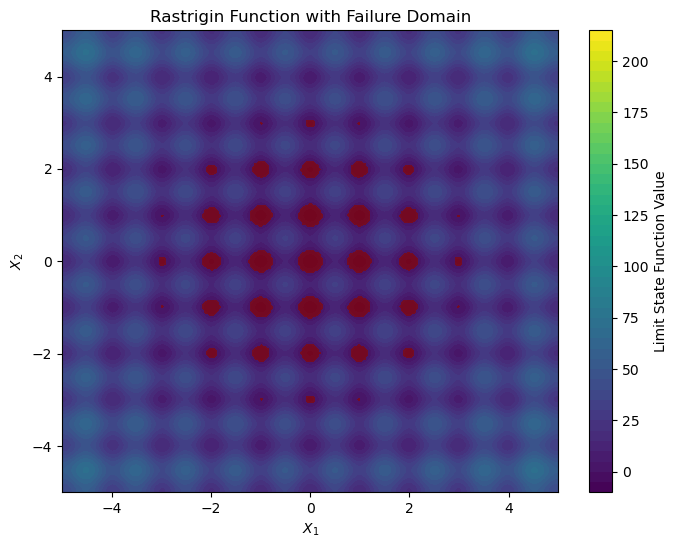

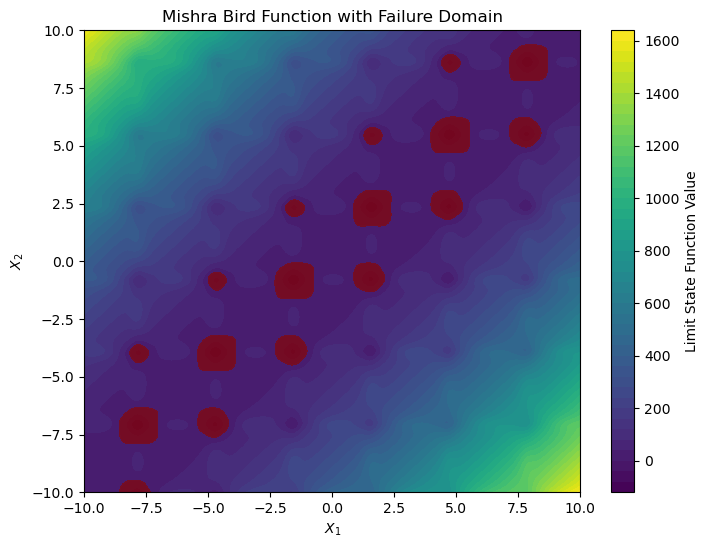

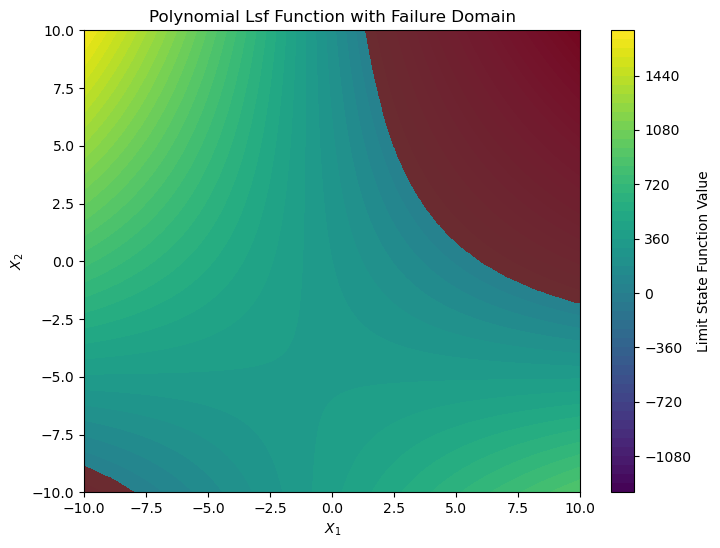

In [5]:
# Parameters
c = 10
yth=350
n_dimensions = 2
n_samples_train = 500000
n_samples_valid = 10000


# Create samples
samples_train_rastrigin = create_samples(n_samples_train, n_dimensions, distribution_type='uniform', low=-5, high=5) 
samples_valid_rastrigin = create_samples(n_samples_valid, n_dimensions, distribution_type='uniform', low=-5, high=5)

samples_train_mishra = create_samples(n_samples_train, n_dimensions, distribution_type='uniform', low=-10, high=10)
samples_valid_mishra = create_samples(n_samples_valid, n_dimensions, distribution_type='uniform', low=-10, high=10)

samples_train_polynomial = create_samples(n_samples_train, 3, distribution_type='uniform', low=-5, high=5)
samples_valid_polynomial = create_samples(n_samples_valid, 3, distribution_type='uniform', low=-5, high=5)

samples_train_polynomial_nd = create_samples(n_samples_train, 16, distribution_type='uniform', low=-5, high=5)
samples_valid_polynomial_nd = create_samples(n_samples_train, 16, distribution_type='uniform', low=-5, high=5)

# Evaluate the limit state functions on the samples for both Rastrigin and Mishra Bird
g_values_train_rastrigin = evaluate_function(samples_train_rastrigin, c=c, function_type='rastrigin')
g_values_valid_rastrigin = evaluate_function(samples_valid_rastrigin, c=c, function_type='rastrigin')

g_values_train_mishra_bird = evaluate_function(samples_train_mishra, c=c, function_type='mishra_bird')
g_values_valid_mishra_bird = evaluate_function(samples_valid_mishra, c=c, function_type='mishra_bird')

g_values_train_polynomial = evaluate_function(samples_train_polynomial, yth=yth, function_type='polynomial_lsf')
g_values_valid_polynomial = evaluate_function(samples_valid_polynomial, yth=yth, function_type='polynomial_lsf')

g_values_train_polynomial_nd = evaluate_function(samples_train_polynomial_nd, yth=50000, function_type='polynomial_lsf_nd')
g_values_valid_polynomial_nd = evaluate_function(samples_valid_polynomial_nd, yth=50000, function_type='polynomial_lsf_nd')

# Estimate the probability of failure for both functions
p_failure_monte_carlo_rastrigin = estimate_probability_of_failure(g_values_train_rastrigin)
p_failure_monte_carlo_mishra_bird = estimate_probability_of_failure(g_values_train_mishra_bird)
p_failure_monte_carlo_polynomial = estimate_probability_of_failure(g_values_train_polynomial)
p_failure_monte_carlo_polynomial_nd = estimate_probability_of_failure(g_values_train_polynomial_nd)

print(f"Monte Carlo Estimated Probability of Failure (Rastrigin): {p_failure_monte_carlo_rastrigin}")
print(f"Monte Carlo Estimated Probability of Failure (Mishra Bird): {p_failure_monte_carlo_mishra_bird}")
print(f"Monte Carlo Estimated Probability of Failure (Polynomial LSF): {p_failure_monte_carlo_polynomial}")
print(f"Monte Carlo Estimated Probability of Failure (Polynomial LSF ND): {p_failure_monte_carlo_polynomial_nd}")

# Visualize the function and failure domain for both functions
visualize_limit_state(c, function_type='rastrigin', lim=5)
visualize_limit_state(c, function_type='mishra_bird')
visualize_limit_state(yth, function_type='polynomial_lsf')

### Predictor Creation for Modified Rastrigin

[2, 234, 325, 289, 128]
	Epoch 001, Val Loss: 0.683092, Ratio predicted: 0.553090, Ratio FN/TN 0.008731, TN: 61277, FP: 84654, FN: 535, TP: 3534
	Epoch 002, Val Loss: 0.660996, Ratio predicted: 0.540503, Ratio FN/TN 0.000826, TN: 60550, FP: 85381, FN: 50, TP: 4019
	Epoch 003, Val Loss: 0.623940, Ratio predicted: 0.502990, Ratio FN/TN 0.000441, TN: 63423, FP: 82508, FN: 28, TP: 4041
	Epoch 004, Val Loss: 0.575448, Ratio predicted: 0.496637, Ratio FN/TN 0.001317, TN: 69095, FP: 76836, FN: 91, TP: 3978
	Epoch 005, Val Loss: 0.516390, Ratio predicted: 0.488503, Ratio FN/TN 0.002080, TN: 77902, FP: 68029, FN: 162, TP: 3907
	Epoch 006, Val Loss: 0.445616, Ratio predicted: 0.487943, Ratio FN/TN 0.002338, TN: 97507, FP: 48424, FN: 228, TP: 3841
	Epoch 007, Val Loss: 0.385773, Ratio predicted: 0.489670, Ratio FN/TN 0.002642, TN: 112412, FP: 33519, FN: 297, TP: 3772
	Epoch 008, Val Loss: 0.364287, Ratio predicted: 0.494943, Ratio FN/TN 0.002403, TN: 117784, FP: 28147, FN: 283, TP: 3786
	Epoch 00

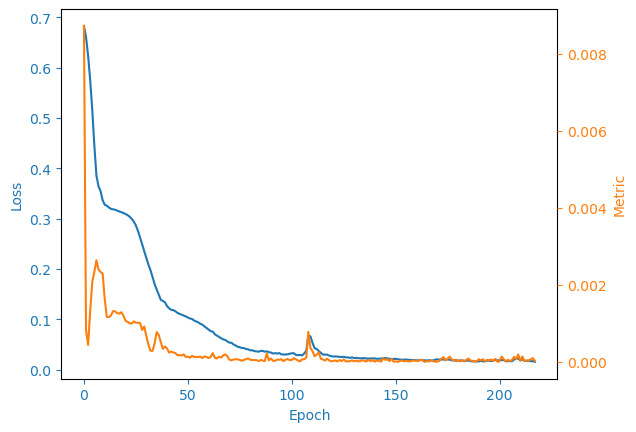

In [6]:
N = n_dimensions
train_failure_ratio_rastrigin = np.where(g_values_train_rastrigin < 0, 1, 0).sum() / n_samples_train
train_success_ratio_rastrigin = np.where(g_values_train_rastrigin >= 0, 1, 0).sum() / n_samples_train
binary_slack_classifier_rastrigin = otaf.surrogate.BinaryClassificationModel(
    N, 2, 
    samples_train_rastrigin, g_values_train_rastrigin, 
    slack_threshold=0.0,
    clamping=True, 
    clamping_threshold=3.0,
    max_epochs=500, 
    batch_size=100000,
    loss_finish=0.016,
    train_size=0.70,
    display_progress_disable=True,
    squeeze_labels=True,
    labels_to_long=True,
    use_dual_target=False
)

lr = 0.01

#binary_slack_classifier_rastrigin.model = otaf.torch.nn.Sequential(
#    *otaf.surrogate.get_custom_mlp_layers([N, 100, 70, 30, 2], activation_class=otaf.torch.nn.GELU)
#)

binary_slack_classifier_rastrigin.model = KAN([N, 10, 4, 2]) # otaf.torch.nn.Sequential(, otaf.torch.nn.Tanhshrink())


binary_slack_classifier_rastrigin.optimizer = otaf.torch.optim.AdamW(
    binary_slack_classifier_rastrigin.parameters(), lr=lr, weight_decay=0.0051
)
weight_rastrigin = otaf.torch.tensor([1.0 / (train_success_ratio_rastrigin + 1e-9), 1.0 / (train_failure_ratio_rastrigin + 1e-9)]).float()
binary_slack_classifier_rastrigin.criterion = otaf.torch.nn.CrossEntropyLoss(weight=weight_rastrigin, reduction='mean', label_smoothing=0.0)
otaf.surrogate.initialize_model_weights(binary_slack_classifier_rastrigin)
binary_slack_classifier_rastrigin.scheduler = otaf.torch.optim.lr_scheduler.ExponentialLR(binary_slack_classifier_rastrigin.optimizer, 1.0)
binary_slack_classifier_rastrigin.train_model()
binary_slack_classifier_rastrigin.plot_results()

### Optimization for Modified Rastrigin

In [7]:
# Evaluate the model on validation samples
pred_class_rastrigin = binary_slack_classifier_rastrigin.evaluate_model(samples_valid_rastrigin).cpu().detach().numpy()
ground_truth_binary_rastrigin = np.where(g_values_valid_rastrigin < 0, 1, 0)  # ground truth for the failures

# Optimize thresholds for Rastrigin
optimization_results_fn_tn_rastrigin = otaf.surrogate.optimize_thresholds_with_alpha(
    pred_class_rastrigin, ground_truth_binary_rastrigin, bounds=[-5.0, 5.0], optimize_for="minimize_fn_maximize_tn"
)
optimization_results_tp_fp_rastrigin = otaf.surrogate.optimize_thresholds_with_alpha(
    pred_class_rastrigin, ground_truth_binary_rastrigin, bounds=[-10.0, 10.0], optimize_for="minimize_fp_maximize_tp", equality_decision="success"
)

print(f"Best Failure Threshold (minimize_fn_maximize_tn, Rastrigin): {optimization_results_fn_tn_rastrigin['best_failure_threshold']}")
print(f"Best Success Threshold (minimize_fn_maximize_tn, Rastrigin): {optimization_results_fn_tn_rastrigin['best_success_threshold']}")
print("Evaluation Metrics (minimize_fn_maximize_tn, Rastrigin):", optimization_results_fn_tn_rastrigin['evaluation'])
print('\n')
print(f"Best Failure Threshold (maximize_tp_minimize_fp, Rastrigin): {optimization_results_tp_fp_rastrigin['best_failure_threshold']}")
print(f"Best Success Threshold (maximize_tp_minimize_fp, Rastrigin): {optimization_results_tp_fp_rastrigin['best_success_threshold']}")
print("Evaluation Metrics (maximize_tp_minimize_fp, Rastrigin):", optimization_results_tp_fp_rastrigin['evaluation'])


   Normal return from subroutine COBYLA

   NFVALS =   40   F = 1.161285E+00    MAXCV = 0.000000E+00
   X = 2.500229E+00  -4.101559E-01

   Normal return from subroutine COBYLA

   NFVALS =   43   F = 1.003397E+00    MAXCV = 0.000000E+00
   X = 2.584889E+00  -9.894596E-02
Best Failure Threshold (minimize_fn_maximize_tn, Rastrigin): 2.5002289535165105
Best Success Threshold (minimize_fn_maximize_tn, Rastrigin): -0.4101559302281809
Evaluation Metrics (minimize_fn_maximize_tn, Rastrigin): {'confusion_matrix': array([[9689,   55],
       [   0,  256]]), 'accuracy': 0.9945, 'precision': 0.8231511254019293, 'recall': 1.0, 'f1_score': 0.9029982363315696, 'true_negatives': 9689, 'false_positives': 55, 'false_negatives': 0, 'true_positives': 256}


Best Failure Threshold (maximize_tp_minimize_fp, Rastrigin): 2.58488918148147
Best Success Threshold (maximize_tp_minimize_fp, Rastrigin): -0.09894595816521315
Evaluation Metrics (maximize_tp_minimize_fp, Rastrigin): {'confusion_matrix': array([[974

### Predictor Creation for Mishra Bird

[2, 234, 325, 289, 128]
	Epoch 001, Val Loss: 0.689102, Ratio predicted: 0.518627, Ratio FN/TN 0.041769, TN: 104241, FP: 37507, FN: 4354, TP: 3898
	Epoch 002, Val Loss: 0.674671, Ratio predicted: 0.519593, Ratio FN/TN 0.043167, TN: 84300, FP: 57448, FN: 3639, TP: 4613
	Epoch 003, Val Loss: 0.644397, Ratio predicted: 0.529807, Ratio FN/TN 0.040093, TN: 85552, FP: 56196, FN: 3430, TP: 4822
	Epoch 004, Val Loss: 0.595876, Ratio predicted: 0.512993, Ratio FN/TN 0.014925, TN: 81138, FP: 60610, FN: 1211, TP: 7041
	Epoch 005, Val Loss: 0.527838, Ratio predicted: 0.494377, Ratio FN/TN 0.005251, TN: 79609, FP: 62139, FN: 418, TP: 7834
	Epoch 006, Val Loss: 0.468305, Ratio predicted: 0.491653, Ratio FN/TN 0.003725, TN: 87784, FP: 53964, FN: 327, TP: 7925
	Epoch 007, Val Loss: 0.428150, Ratio predicted: 0.493663, Ratio FN/TN 0.007656, TN: 95613, FP: 46135, FN: 732, TP: 7520
	Epoch 008, Val Loss: 0.406764, Ratio predicted: 0.491000, Ratio FN/TN 0.007126, TN: 98096, FP: 43652, FN: 699, TP: 7553
	Ep

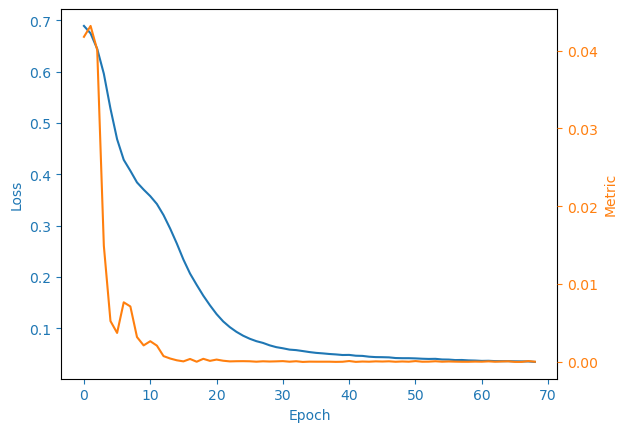

In [8]:
train_failure_ratio_mishra_bird = np.where(g_values_train_mishra_bird < 0, 1, 0).sum() / n_samples_train
train_success_ratio_mishra_bird = np.where(g_values_train_mishra_bird >= 0, 1, 0).sum() / n_samples_train
binary_slack_classifier_mishra_bird = otaf.surrogate.BinaryClassificationModel(
    N, 2, 
    samples_train_mishra, g_values_train_mishra_bird, 
    slack_threshold=0.0,
    clamping=True, 
    clamping_threshold=1.0,
    max_epochs=500, 
    batch_size=70000, 
    train_size=0.70,
    loss_finish=0.035,
    display_progress_disable=True,
    squeeze_labels=True,
    labels_to_long=True,
    use_dual_target=False
)

lr = 0.01


#binary_slack_classifier_mishra_bird.model = otaf.torch.nn.Sequential(
#    *otaf.surrogate.get_custom_mlp_layers([N, 100, 70, 30, 2], activation_class=otaf.torch.nn.GELU)
#)

binary_slack_classifier_mishra_bird.model = KAN([N, 10, 4, 2]) # otaf.torch.nn.Sequential(, otaf.torch.nn.Tanhshrink())


binary_slack_classifier_mishra_bird.optimizer = otaf.torch.optim.AdamW(
    binary_slack_classifier_mishra_bird.parameters(), lr=lr, weight_decay=0.001
)
weight_mishra_bird = otaf.torch.tensor([1.0 / (train_success_ratio_mishra_bird + 1e-9), 1.0 / (train_failure_ratio_mishra_bird + 1e-9)]).float()
binary_slack_classifier_mishra_bird.criterion = otaf.torch.nn.CrossEntropyLoss(weight=weight_mishra_bird, reduction='mean', label_smoothing=0.0)
otaf.surrogate.initialize_model_weights(binary_slack_classifier_mishra_bird)
binary_slack_classifier_mishra_bird.scheduler = otaf.torch.optim.lr_scheduler.ExponentialLR(binary_slack_classifier_mishra_bird.optimizer, 1.0)
binary_slack_classifier_mishra_bird.train_model()
binary_slack_classifier_mishra_bird.plot_results()

### Optimization for Mishra Bird

In [9]:
# Evaluate the model on validation samples
pred_class_mishra_bird = binary_slack_classifier_mishra_bird.evaluate_model(samples_valid_mishra).cpu().detach().numpy()
ground_truth_binary_mishra_bird = np.where(g_values_valid_mishra_bird < 0, 1, 0)  # ground truth for the failures

# Optimize thresholds for Mishra Bird
optimization_results_fn_tn_mishra_bird = otaf.surrogate.optimize_thresholds_with_alpha(
    pred_class_mishra_bird, ground_truth_binary_mishra_bird, bounds=[-5.0, 5.0], optimize_for="minimize_fn_maximize_tn"
)
optimization_results_tp_fp_mishra_bird = otaf.surrogate.optimize_thresholds_with_alpha(
    pred_class_mishra_bird, ground_truth_binary_mishra_bird, bounds=[-5.0, 5.0], optimize_for="minimize_fp_maximize_tp", equality_decision="success"
)

print(f"Best Failure Threshold (minimize_fn_maximize_tn, Mishra Bird): {optimization_results_fn_tn_mishra_bird['best_failure_threshold']}")
print(f"Best Success Threshold (minimize_fn_maximize_tn, Mishra Bird): {optimization_results_fn_tn_mishra_bird['best_success_threshold']}")
print("Evaluation Metrics (minimize_fn_maximize_tn, Mishra Bird):", optimization_results_fn_tn_mishra_bird['evaluation'])
print('\n')
print(f"Best Failure Threshold (maximize_tp_minimize_fp, Mishra Bird): {optimization_results_tp_fp_mishra_bird['best_failure_threshold']}")
print(f"Best Success Threshold (maximize_tp_minimize_fp, Mishra Bird): {optimization_results_tp_fp_mishra_bird['best_success_threshold']}")
print("Evaluation Metrics (maximize_tp_minimize_fp, Mishra Bird):", optimization_results_tp_fp_mishra_bird['evaluation'])


   Normal return from subroutine COBYLA

   NFVALS =   36   F = 1.240523E+00    MAXCV = 0.000000E+00
   X = 2.500000E+00  -7.812500E-02

   Normal return from subroutine COBYLA

   NFVALS =   26   F = 1.436891E+00    MAXCV =-0.000000E+00
   X = 5.000000E+00   0.000000E+00
Best Failure Threshold (minimize_fn_maximize_tn, Mishra Bird): 2.5
Best Success Threshold (minimize_fn_maximize_tn, Mishra Bird): -0.07812500000000001
Evaluation Metrics (minimize_fn_maximize_tn, Mishra Bird): {'confusion_matrix': array([[9289,  167],
       [   0,  544]]), 'accuracy': 0.9833, 'precision': 0.7651195499296765, 'recall': 1.0, 'f1_score': 0.8669322709163347, 'true_negatives': 9289, 'false_positives': 167, 'false_negatives': 0, 'true_positives': 544}


Best Failure Threshold (maximize_tp_minimize_fp, Mishra Bird): 5.0
Best Success Threshold (maximize_tp_minimize_fp, Mishra Bird): 0.0
Evaluation Metrics (maximize_tp_minimize_fp, Mishra Bird): {'confusion_matrix': array([[9456,    0],
       [ 544,    0]])

### Predictor Creation for Polynomial (Chabridon)

[3, 239, 327, 290, 128]
	Epoch 001, Val Loss: 0.648328, Ratio predicted: 0.115417, Ratio FN/TN 0.000000, TN: 0, FP: 140381, FN: 0, TP: 9619
	Epoch 002, Val Loss: 0.598186, Ratio predicted: 0.222090, Ratio FN/TN 0.000000, TN: 17848, FP: 122533, FN: 0, TP: 9619
	Epoch 003, Val Loss: 0.536507, Ratio predicted: 0.345253, Ratio FN/TN 0.000000, TN: 48785, FP: 91596, FN: 0, TP: 9619
	Epoch 004, Val Loss: 0.468935, Ratio predicted: 0.407633, Ratio FN/TN 0.000000, TN: 66283, FP: 74098, FN: 0, TP: 9619
	Epoch 005, Val Loss: 0.407018, Ratio predicted: 0.440267, Ratio FN/TN 0.000000, TN: 78333, FP: 62048, FN: 0, TP: 9619
	Epoch 006, Val Loss: 0.353613, Ratio predicted: 0.457987, Ratio FN/TN 0.000000, TN: 89112, FP: 51269, FN: 0, TP: 9619
	Epoch 007, Val Loss: 0.296879, Ratio predicted: 0.468940, Ratio FN/TN 0.000000, TN: 100518, FP: 39863, FN: 0, TP: 9619
	Epoch 008, Val Loss: 0.234019, Ratio predicted: 0.476280, Ratio FN/TN 0.000000, TN: 112259, FP: 28122, FN: 0, TP: 9619
	Epoch 009, Val Loss: 0.

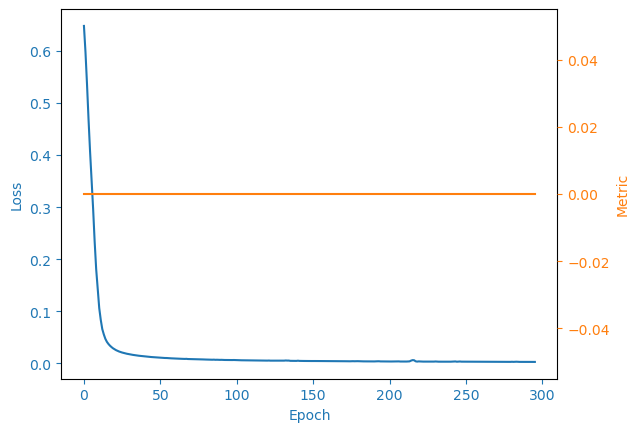

In [10]:
train_failure_ratio_polynomial = np.where(g_values_train_polynomial < 0, 1, 0).sum() / n_samples_train
train_success_ratio_polynomial = np.where(g_values_train_polynomial >= 0, 1, 0).sum() / n_samples_train
binary_slack_classifier_polynomial = otaf.surrogate.BinaryClassificationModel(
    3, 2, 
    samples_train_polynomial, g_values_train_polynomial, 
    slack_threshold=0.0,
    clamping=True, 
    clamping_threshold=1.0,
    max_epochs=1000, 
    batch_size=100000, 
    train_size=0.70,
    loss_finish=0.0025,
    display_progress_disable=True,
    squeeze_labels=True,
    labels_to_long=True,
    use_dual_target=False
)

lr = 0.001

binary_slack_classifier_polynomial.model = otaf.torch.nn.Sequential(
    *otaf.surrogate.get_custom_mlp_layers([3, 100, 70, 30, 2], activation_class=otaf.torch.nn.GELU)
)

binary_slack_classifier_polynomial.optimizer = otaf.torch.optim.AdamW(
    binary_slack_classifier_polynomial.parameters(), lr=lr, weight_decay=0.001
)
weight_polynomial = otaf.torch.tensor([1.0 / (train_success_ratio_polynomial + 1e-9), 1.0 / (train_failure_ratio_polynomial + 1e-9)]).float()
binary_slack_classifier_polynomial.criterion = otaf.torch.nn.CrossEntropyLoss(weight=weight_polynomial, reduction='mean', label_smoothing=0.0)
otaf.surrogate.initialize_model_weights(binary_slack_classifier_polynomial)
binary_slack_classifier_polynomial.scheduler = otaf.torch.optim.lr_scheduler.ExponentialLR(binary_slack_classifier_polynomial.optimizer, 1.0)
binary_slack_classifier_polynomial.train_model()
binary_slack_classifier_polynomial.plot_results()


### Optimization for Polynomial

In [11]:
# Evaluate the model on validation samples
pred_class_polynomial = binary_slack_classifier_polynomial.evaluate_model(samples_valid_polynomial).cpu().detach().numpy()
ground_truth_binary_polynomial = np.where(g_values_valid_polynomial < 0, 1, 0)  # ground truth for the failures

# Optimize thresholds for Polynomial LSF
optimization_results_fn_tn_polynomial = otaf.surrogate.optimize_thresholds_with_alpha(
    pred_class_polynomial, ground_truth_binary_polynomial, bounds=[-5.0, 5.0], optimize_for="minimize_fn_maximize_tn"
)
optimization_results_tp_fp_polynomial = otaf.surrogate.optimize_thresholds_with_alpha(
    pred_class_polynomial, ground_truth_binary_polynomial, bounds=[-10.0, 10.0], optimize_for="minimize_fp_maximize_tp", equality_decision="success"
)

print(f"Best Failure Threshold (minimize_fn_maximize_tn, Polynomial): {optimization_results_fn_tn_polynomial['best_failure_threshold']}")
print(f"Best Success Threshold (minimize_fn_maximize_tn, Polynomial): {optimization_results_fn_tn_polynomial['best_success_threshold']}")
print("Evaluation Metrics (minimize_fn_maximize_tn, Polynomial):", optimization_results_fn_tn_polynomial['evaluation'])
print('\n')
print(f"Best Failure Threshold (maximize_tp_minimize_fp, Polynomial): {optimization_results_tp_fp_polynomial['best_failure_threshold']}")
print(f"Best Success Threshold (maximize_tp_minimize_fp, Polynomial): {optimization_results_tp_fp_polynomial['best_success_threshold']}")
print("Evaluation Metrics (maximize_tp_minimize_fp, Polynomial):", optimization_results_tp_fp_polynomial['evaluation'])



   Normal return from subroutine COBYLA

   NFVALS =   33   F = 1.002196E+00    MAXCV = 0.000000E+00
   X = 2.500144E+00  -4.687500E-01

   Normal return from subroutine COBYLA

   NFVALS =   36   F = 1.000223E+00    MAXCV = 0.000000E+00
   X = 1.642990E+00  -1.907524E-02
Best Failure Threshold (minimize_fn_maximize_tn, Polynomial): 2.5001437348684368
Best Success Threshold (minimize_fn_maximize_tn, Polynomial): -0.46874997796297285
Evaluation Metrics (minimize_fn_maximize_tn, Polynomial): {'confusion_matrix': array([[9366,    2],
       [   0,  632]]), 'accuracy': 0.9998, 'precision': 0.9968454258675079, 'recall': 1.0, 'f1_score': 0.9984202211690364, 'true_negatives': 9366, 'false_positives': 2, 'false_negatives': 0, 'true_positives': 632}


Best Failure Threshold (maximize_tp_minimize_fp, Polynomial): 1.64298951676864
Best Success Threshold (maximize_tp_minimize_fp, Polynomial): -0.01907524064201539
Evaluation Metrics (maximize_tp_minimize_fp, Polynomial): {'confusion_matrix': array

### Predictor Creation for Polynomial ND (Chabridon)

[16, 308, 360, 300, 128]
	Epoch 001, Val Loss: 0.678656, Ratio predicted: 0.491927, Ratio FN/TN 0.154628, TN: 47307, FP: 70700, FN: 7315, TP: 24678
	Epoch 002, Val Loss: 0.655006, Ratio predicted: 0.493063, Ratio FN/TN 0.166403, TN: 72559, FP: 45448, FN: 12074, TP: 19919
	Epoch 003, Val Loss: 0.626005, Ratio predicted: 0.493890, Ratio FN/TN 0.150600, TN: 79688, FP: 38319, FN: 12001, TP: 19992
	Epoch 004, Val Loss: 0.564535, Ratio predicted: 0.497343, Ratio FN/TN 0.106297, TN: 82533, FP: 35474, FN: 8773, TP: 23220
	Epoch 005, Val Loss: 0.529058, Ratio predicted: 0.500297, Ratio FN/TN 0.070612, TN: 77806, FP: 40201, FN: 5494, TP: 26499
	Epoch 006, Val Loss: 0.505319, Ratio predicted: 0.500893, Ratio FN/TN 0.067170, TN: 79961, FP: 38046, FN: 5371, TP: 26622
	Epoch 007, Val Loss: 0.483722, Ratio predicted: 0.503273, Ratio FN/TN 0.056408, TN: 78748, FP: 39259, FN: 4442, TP: 27551
	Epoch 008, Val Loss: 0.472868, Ratio predicted: 0.504810, Ratio FN/TN 0.049634, TN: 78313, FP: 39694, FN: 3887,

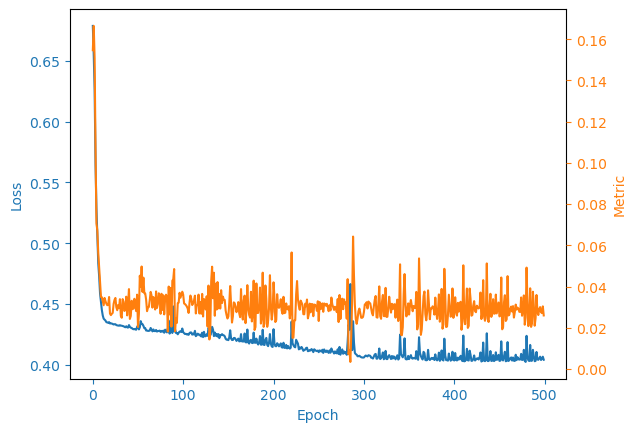

In [12]:
train_failure_ratio_polynomial_nd = np.where(g_values_train_polynomial_nd < 0, 1, 0).sum() / n_samples_train
train_success_ratio_polynomial_nd = np.where(g_values_train_polynomial_nd >= 0, 1, 0).sum() / n_samples_train
binary_slack_classifier_polynomial_nd = otaf.surrogate.BinaryClassificationModel(
    16, 2, 
    samples_train_polynomial_nd, g_values_train_polynomial_nd, 
    slack_threshold=0.0,
    clamping=True, 
    clamping_threshold=1.0,
    max_epochs=500, 
    batch_size=100000, 
    train_size=0.70,
    loss_finish=0.075,
    display_progress_disable=True,
    squeeze_labels=True,
    labels_to_long=True,
    use_dual_target=False
)

lr = 0.01

#binary_slack_classifier_polynomial_nd.model = otaf.torch.nn.Sequential(
#    *otaf.surrogate.get_custom_mlp_layers([3, 100, 70, 30, 2], activation_class=otaf.torch.nn.GELU)
#)

binary_slack_classifier_polynomial_nd.model = KAN([16, 20, 10, 2])


binary_slack_classifier_polynomial_nd.optimizer = otaf.torch.optim.AdamW(
    binary_slack_classifier_polynomial_nd.parameters(), lr=lr, weight_decay=0.001
)
weight_polynomial_nd = otaf.torch.tensor([1.0 / (train_success_ratio_polynomial_nd + 1e-9), 1.0 / (train_failure_ratio_polynomial_nd + 1e-9)]).float()
binary_slack_classifier_polynomial_nd.criterion = otaf.torch.nn.CrossEntropyLoss(weight=weight_polynomial_nd, reduction='mean', label_smoothing=0.0)
otaf.surrogate.initialize_model_weights(binary_slack_classifier_polynomial_nd)
binary_slack_classifier_polynomial_nd.scheduler = otaf.torch.optim.lr_scheduler.ExponentialLR(binary_slack_classifier_polynomial_nd.optimizer, 1.0)
binary_slack_classifier_polynomial_nd.train_model()
binary_slack_classifier_polynomial_nd.plot_results()


### Optimization for Polynomial ND

In [13]:
# Evaluate the model on validation samples
pred_class_polynomial_nd = binary_slack_classifier_polynomial_nd.evaluate_model(samples_valid_polynomial_nd).cpu().detach().numpy()
ground_truth_binary_polynomial_nd = np.where(g_values_valid_polynomial_nd < 0, 1, 0)  # ground truth for the failures

# Optimize thresholds for Polynomial LSF
optimization_results_fn_tn_polynomial_nd = otaf.surrogate.optimize_thresholds_with_alpha(
    pred_class_polynomial_nd, ground_truth_binary_polynomial_nd, bounds=[-5.0, 5.0], optimize_for="minimize_fn_maximize_tn"
)
optimization_results_tp_fp_polynomial_nd = otaf.surrogate.optimize_thresholds_with_alpha(
    pred_class_polynomial_nd, ground_truth_binary_polynomial_nd, bounds=[-5.0, 5.0], optimize_for="minimize_fp_maximize_tp", equality_decision="success"
)

print(f"Best Failure Threshold (minimize_fn_maximize_tn, Polynomial): {optimization_results_fn_tn_polynomial_nd['best_failure_threshold']}")
print(f"Best Success Threshold (minimize_fn_maximize_tn, Polynomial): {optimization_results_fn_tn_polynomial_nd['best_success_threshold']}")
print("Evaluation Metrics (minimize_fn_maximize_tn, Polynomial):", optimization_results_fn_tn_polynomial_nd['evaluation'])
print('\n')
print(f"Best Failure Threshold (maximize_tp_minimize_fp, Polynomial): {optimization_results_tp_fp_polynomial_nd['best_failure_threshold']}")
print(f"Best Success Threshold (maximize_tp_minimize_fp, Polynomial): {optimization_results_tp_fp_polynomial_nd['best_success_threshold']}")
print("Evaluation Metrics (maximize_tp_minimize_fp, Polynomial):", optimization_results_tp_fp_polynomial_nd['evaluation'])

/home/ksimady/anaconda3/envs/anr-dev/lib/python3.11/site-packages/otaf-0.1-py3.11.egg/otaf/surrogate/_binary_threshold_classifier.py:519: RuntimeWarning: overflow encountered in scalar power
/home/ksimady/anaconda3/envs/anr-dev/lib/python3.11/site-packages/otaf-0.1-py3.11.egg/otaf/surrogate/_binary_threshold_classifier.py:519: RuntimeWarning: overflow encountered in scalar power
/home/ksimady/anaconda3/envs/anr-dev/lib/python3.11/site-packages/otaf-0.1-py3.11.egg/otaf/surrogate/_binary_threshold_classifier.py:522: RuntimeWarning: overflow encountered in scalar power



   NFVALS =    3   F = 2.096567E+23    MAXCV = 0.000000E+00
   X = 0.000000E+00   2.500000E+00

   NFVALS =    3   F = 2.375455E+01    MAXCV = 0.000000E+00
   X = 2.500000E+00   0.000000E+00
Best Failure Threshold (minimize_fn_maximize_tn, Polynomial): 0.0
Best Success Threshold (minimize_fn_maximize_tn, Polynomial): 2.5
Evaluation Metrics (minimize_fn_maximize_tn, Polynomial): {'confusion_matrix': array([[214796, 177835],
       [    50, 107319]]), 'accuracy': 0.64423, 'precision': 0.3763545312357533, 'recall': 0.9995343162365301, 'f1_score': 0.5468163649009102, 'true_negatives': 214796, 'false_positives': 177835, 'false_negatives': 50, 'true_positives': 107319}


Best Failure Threshold (maximize_tp_minimize_fp, Polynomial): 2.5
Best Success Threshold (maximize_tp_minimize_fp, Polynomial): 0.0
Evaluation Metrics (maximize_tp_minimize_fp, Polynomial): {'confusion_matrix': array([[392631,      0],
       [107369,      0]]), 'accuracy': 0.785262, 'precision': 0, 'recall': 0.0, 'f1_score

In [14]:
# Real failure domain from the limit state function
x1 = np.linspace(-10, 10, 500)
x2 = np.linspace(-10, 10, 500)
X1, X2 = np.meshgrid(x1, x2)
sampleX = np.stack([X1.flatten(), X2.flatten()]).T
sampleX.shape

(250000, 2)

### Classification and Plotting for Modified Rastrigin

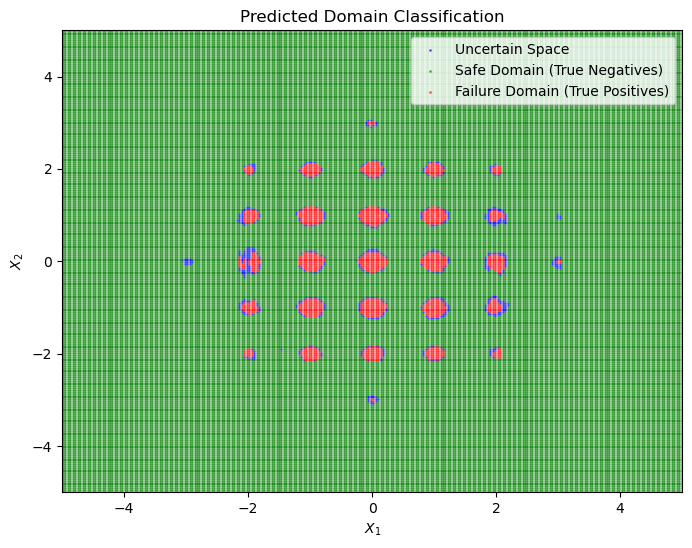

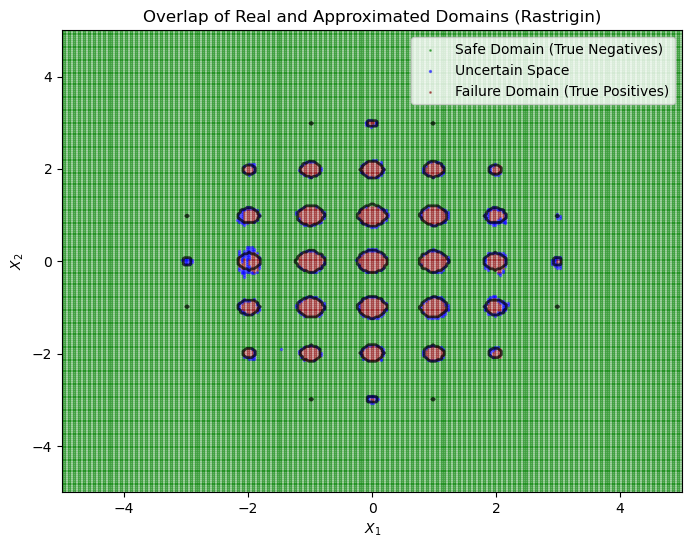

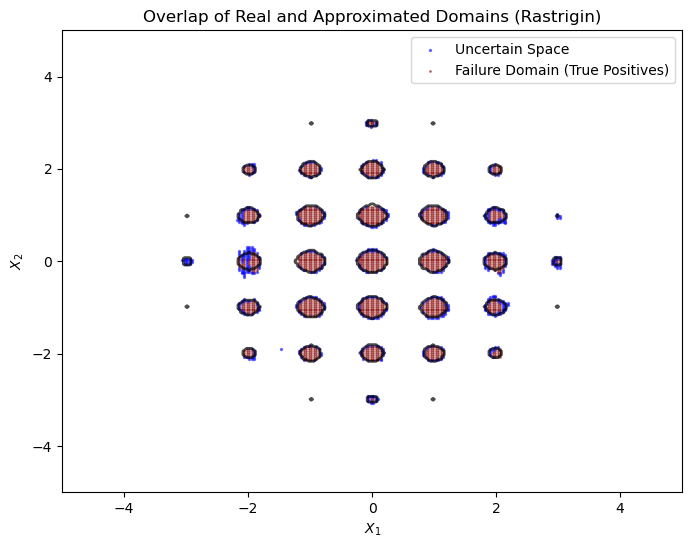

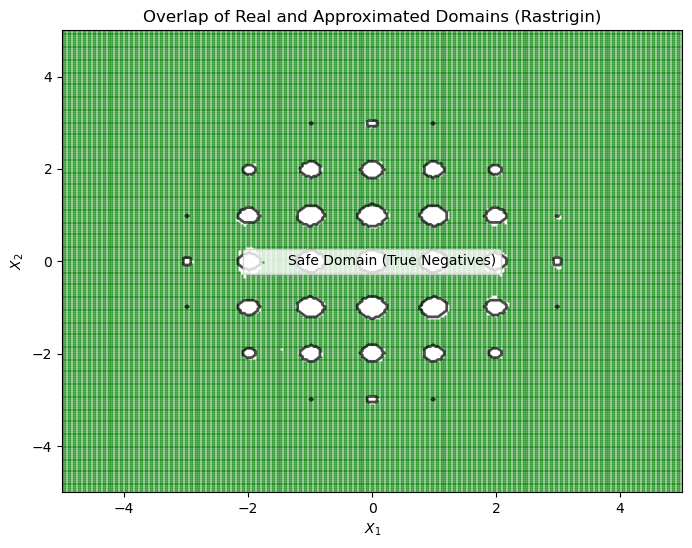

In [15]:
# Classify samples for Rastrigin
classifications_rastrigin = classify_samples(
    binary_slack_classifier_rastrigin,
    sampleX,
    optimization_results_fn_tn_rastrigin,
    optimization_results_tp_fp_rastrigin
)

# Plot the predicted domain for Rastrigin
plot_predicted_domain(sampleX, classifications_rastrigin, lim=5)

# Plot the overlap of real and approximated domainsµfor Rastrigin
plot_overlap_real_approximated(sampleX, classifications_rastrigin, c, function_type='rastrigin', lim=5)
plot_overlap_real_approximated(sampleX, classifications_rastrigin, c, 500, 1, 0, 1, function_type='rastrigin', lim=5)
plot_overlap_real_approximated(sampleX, classifications_rastrigin, c, 500, 0, 1, 0, function_type='rastrigin', lim=5)


### Classification and Plotting for Mishra Bird

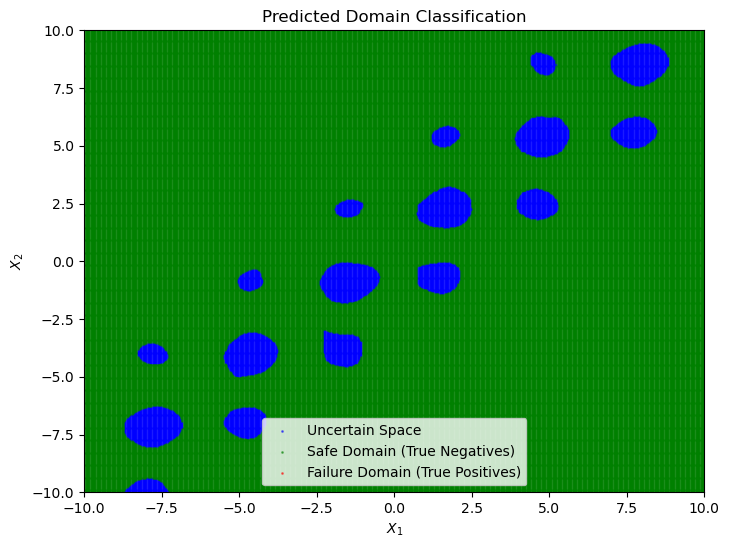

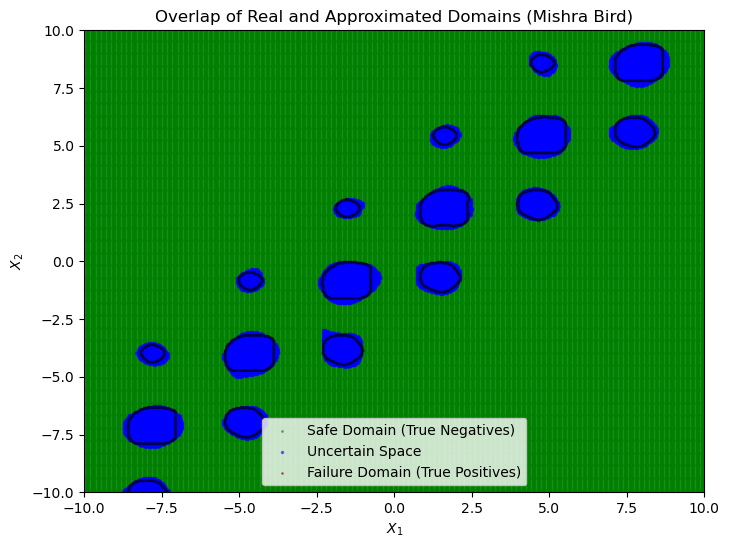

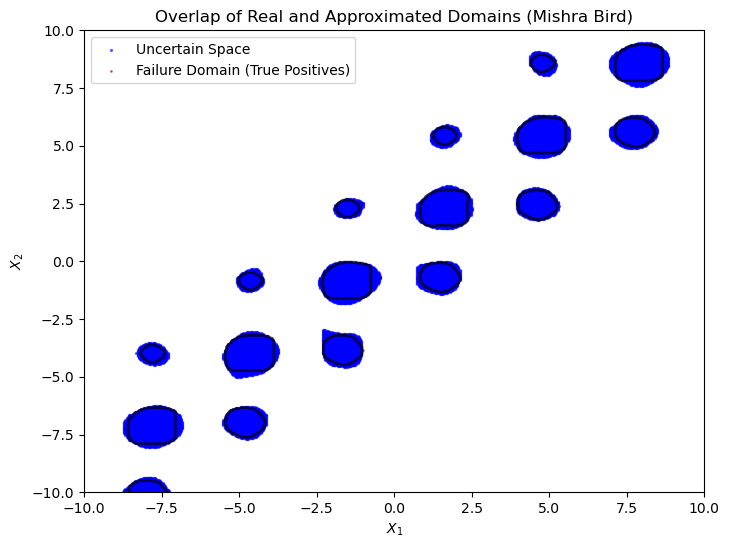

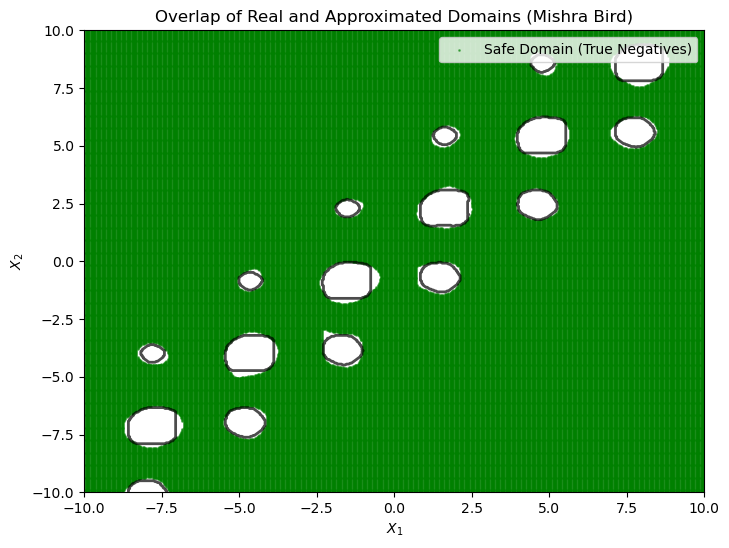

In [16]:
# Classify samples for Mishra Bird
classifications_mishra_bird = classify_samples(
    binary_slack_classifier_mishra_bird,
    sampleX,
    optimization_results_fn_tn_mishra_bird,
    optimization_results_tp_fp_mishra_bird
)

# Plot the predicted domain for Mishra Bird
plot_predicted_domain(sampleX, classifications_mishra_bird)

# Plot the overlap of real and approximated domains for Mishra Bird
plot_overlap_real_approximated(sampleX, classifications_mishra_bird, c, function_type='mishra_bird')
plot_overlap_real_approximated(sampleX, classifications_mishra_bird, c, 500, 1, 0, 1, function_type='mishra_bird')
plot_overlap_real_approximated(sampleX, classifications_mishra_bird, c, 500, 0, 1, 0, function_type='mishra_bird')
